In [1]:
import os
import numpy
import numpy.random

import tensorflow as tf
import edward as ed
from edward.models import Bernoulli, Exponential, Normal, Gamma, Empirical

import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
Use the retry module or similar alternatives.


Simulated data:

In [2]:
PAGE_COUNT = 10
PAGES_PER_SESSION_PRIOR = 5
NUMBER_OF_SESSIONS = 100

DECAY = 2.

# Simulate some trend
TREND = PAGES_PER_SESSION_PRIOR * numpy.exp(- numpy.arange(NUMBER_OF_SESSIONS) * DECAY 
                                            / NUMBER_OF_SESSIONS) 
         

# Sample data around the trend
DATA = numpy.minimum(PAGE_COUNT, 
                     numpy.maximum(1, numpy.round(numpy.random.exponential(TREND))))

print("Trend from {:.2f} to {:.2f}".format(TREND[0], TREND[-1]))
print("Data:", DATA)

# Convert to tensor
DATA = tf.convert_to_tensor(DATA, numpy.int32)
with tf.Session() as s:
    print(s.run(DATA))

Trend from 5.00 to 0.69
Data: [ 2.  5.  1. 10.  2.  1.  1.  1.  9.  2.  9.  1.  6.  5.  2.  4.  2.  1.
  1.  3.  1. 10.  1.  7.  8.  6.  4.  1.  2.  4.  1.  1.  2.  1.  4.  1.
  1.  1.  3.  3.  1.  1.  2.  1.  1.  1.  2.  2.  1.  3.  3.  3.  2.  1.
  1.  5.  1.  1.  1.  3.  1.  1.  2.  2.  2.  1.  1.  1.  1.  3.  2.  1.
  2.  1.  2.  1.  2.  2.  1.  1.  1.  1.  4.  3.  1.  3.  2.  1.  2.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.]
[ 2  5  1 10  2  1  1  1  9  2  9  1  6  5  2  4  2  1  1  3  1 10  1  7
  8  6  4  1  2  4  1  1  2  1  4  1  1  1  3  3  1  1  2  1  1  1  2  2
  1  3  3  3  2  1  1  5  1  1  1  3  1  1  2  2  2  1  1  1  1  3  2  1
  2  1  2  1  2  2  1  1  1  1  4  3  1  3  2  1  2  1  1  1  1  1  1  1
  1  1  2  1]


Let's define the model of clicking through a campaign:

In [3]:
def update_beliefs(beliefs, i, j, bandwidth):
    
    # updates the beliefs with new evidence
    update = tf.scatter_nd(tf.stack([tf.stack([i , j])]),
                           tf.constant([1.]),
                           beliefs.shape)
    beliefs = beliefs + update
    
    # compute new evidence in the updated row
    evidence = tf.reduce_sum(beliefs[i, :])
    
    # if the evidence is greater than the bandwidth,
    # scale down
    scale = bandwidth / evidence
    beliefs = tf.cond(scale < 1.,
                      lambda: beliefs * 
                              tf.exp(tf.scatter_nd(tf.stack([tf.stack([i, tf.constant(0)]),
                                                             tf.stack([i, tf.constant(1)])]),
                                                   tf.log(tf.stack([scale, scale])),
                                                   beliefs.shape)),
                      lambda: beliefs)
    return beliefs

In [4]:
foo = update_beliefs(tf.constant([[3., 4.], [3., 3.]]), tf.constant(1), tf.constant(0), tf.constant(1.))
with tf.Session() as s:
    print(s.run(foo))

[[3.         4.        ]
 [0.5714286  0.42857146]]


In [5]:
def model(bandwidth, page_count, number_of_sessions, data):
    churn_probability = 1 / PAGES_PER_SESSION_PRIOR
    beliefs = tf.stack([2 * churn_probability * tf.ones(page_count),
                        2 * (1 - churn_probability) * tf.ones(page_count)],
                       axis=1)
 
    def over_sessions(state, isession):
       
        def over_pages(beliefs, ipage, last_page):
            last_page = tf.logical_or(tf.equal(ipage, data[isession] - 1),
                                      tf.equal(ipage, page_count - 1))
            beliefs = update_beliefs(beliefs, ipage, 
                                     tf.cond(last_page, lambda: 0, lambda: 1),
                                     bandwidth) 
            return (beliefs, ipage + 1, last_page)

        def continues(lefts, ipage, last_page):
            return tf.logical_not(last_page)

 
        beliefs, _ = state
        beliefs, _, _ = tf.while_loop(continues, over_pages, (beliefs, 0, tf.constant(False)))
        
        return beliefs, beliefs
    
    _, beliefs = tf.scan(over_sessions, tf.range(number_of_sessions), (beliefs, beliefs))
    
    # Prepend to each session's lefts 0 and append 1 to get the correct number: never
    # left after 0 pages, always left by reaching the end
    scattered_lefts = Bernoulli(probs=beliefs[:, :, 0] / (beliefs[:, :, 0] + beliefs[:, :, 1]))
    scattered_lefts = tf.concat([tf.zeros((scattered_lefts.shape[0], 1), dtype=tf.int32),
                                 scattered_lefts[:, :-1],
                                 tf.ones((scattered_lefts.shape[0], 1), dtype=tf.int32)],
                                axis=1)
    lefts = tf.argmax(scattered_lefts, axis=1)
    
    return Normal(tf.cast(lefts, dtype=tf.float32), scale=0.5)

In [6]:
foo = model(20., PAGE_COUNT, NUMBER_OF_SESSIONS, DATA)
with tf.Session() as s:
    a = 0.
    b = 0.
    K = 100
    for i in range(100):
        res = s.run(foo)
        a += res[:len(res)//4].mean()
        b += res[-len(res)//4:].mean()
    a /= K
    b /= K
    print(a, b)

3.7018194961547852 2.1473103988170625


## Full model

In [7]:
bandwidth = Exponential(0.05)
pps = model(bandwidth, PAGE_COUNT, NUMBER_OF_SESSIONS, DATA)

Let's just see we still can run it:

[3.52843086 4.30622523 4.14333174 4.78082602 4.0049113  4.23182682
 3.01103918 2.66171502 3.60788636 4.2115465  4.25786999 0.97385199
 4.93612018 3.70585549 3.72706109 2.67160873 3.64784743 4.51660697
 3.04817194 3.2430486  1.71734742 4.72047197 1.82122263 7.13798501
 4.21300018 5.22982883 4.70092285 3.3750795  2.57409145 3.89663187
 2.24662234 2.10621402 1.39891122 1.97434364 3.43949176 2.61049151
 1.84092662 1.43143365 3.00309854 2.73349021 1.31650637 2.05046834
 3.19836616 2.08061858 1.5287165  2.04260082 1.92862712 2.81606605
 1.92731714 1.79837242 2.31738225 2.78452327 2.67583081 2.43817768
 2.34534269 1.74398236 2.90815648 1.85725644 1.72619004 1.58633835
 1.33987107 2.46599867 2.10975792 1.29805822 1.61985851 0.8879691
 3.38104306 1.58808626 1.6521566  2.17480413 2.18772185 1.61344308
 3.20115997 2.7165592  2.02319593 1.12263737 1.35030053 3.09541939
 2.44869104 1.20227835 1.82532458 2.01198247 1.73009856 4.40043453
 2.83109556 3.26716626 2.25806324 1.73984808 1.89622455 1.39666

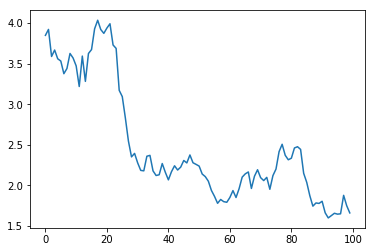

In [8]:
with tf.Session() as s:
    resum = numpy.zeros(DATA.shape[0])
    K = 10
    for i in range(K):
        res = s.run(pps)
        resum += res
    resum /= K
    print(resum)
    d = 10
    plt.plot([resum[i:i+d].mean() for i in range(len(resum))])

## MH Monte Carlo

Slow but should work.

In [9]:
N = 1000
with tf.variable_scope("importance", reuse=tf.AUTO_REUSE):
    sampled_bandwidth = Empirical(params=tf.get_variable(
        "sampled_bandwidth", 
        [N], 
        initializer=tf.constant_initializer(10.)))
    proposed_bandwidth = Normal(loc=sampled_bandwidth, scale=1.)

    mh_inference = ed.MetropolisHastings({bandwidth: sampled_bandwidth}, 
                                         {bandwidth: proposed_bandwidth},
                                         data={pps: tf.cast(DATA, tf.float32)})

In [10]:
mh_inference.run()

sess = ed.get_session()
mean, stddev = sess.run([sampled_bandwidth.mean(), sampled_bandwidth.stddev()])
print("posterior: mean={:.4f}, stddev={:.4f}".format(mean, stddev))

1000/1000 [100%] ██████████████████████████████ Elapsed: 38s | Acceptance Rate: 0.357
posterior: mean=7.4226, stddev=3.9801


In [ ]:
_ = plt.hist(sess.run(sampled_bandwidth.sample(1000)), density=True)
_ = plt.xlabel("bandwidth")


## Variational Inference


In [ ]:
with tf.variable_scope("variational", reuse=tf.AUTO_REUSE):
    shape = tf.get_variable("shape", (), initializer=tf.constant_initializer(1.))
    scale = tf.get_variable("scale", (), initializer=tf.constant_initializer(20.))
    qbandwidth = Gamma(tf.nn.softplus(shape), 1. / tf.nn.softplus(scale))

variational_inference = ed.KLqp({bandwidth: qbandwidth}, 
                                data={pps: tf.cast(DATA, tf.float32)})

In [ ]:
variational_inference.run(n_iter=1000)

In [ ]:
alpha = qbandwidth.concentration.eval()
beta = qbandwidth.rate.eval()
mean = alpha / beta
stddev = numpy.sqrt(mean / beta)
print("posterior: mean={:.4f} stddev={:.4f}".format(mean, stddev))

In [ ]:
_ = plt.hist(qbandwidth.sample(1000).eval(), density=True)
_ = plt.xlabel("bandwidth")